<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/FT_FILOSOFO_MISTRAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install unsloth trl -q

In [1]:
!nvidia-smi

Fri Feb 20 18:14:44 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 580.82.07              Driver Version: 580.82.07      CUDA Version: 13.0     |
+-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   37C    P8             13W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
import os
import json
import torch
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments
from datasets import load_dataset

# 1. Environment & Configuration
os.environ["WANDB_DISABLED"] = "true" # Prevents the login prompt hang
max_seq_length = 2048
model_name = "unsloth/mistral-7b-v0.3-bnb-4bit"

# 2. Load Model and Tokenizer
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_name,
    max_seq_length = max_seq_length,
    load_in_4bit = True,
)

# 3. Add LoRA Adapters (Optimized for NVIDIA L4)
model = FastLanguageModel.get_peft_model(
    model,
    r = 16,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
)

In [ ]:
# 4. Generate Video-Referenced Dataset
video_philosophy_data = [
    {"philosophy_school": "Socrates", "question": "I consider myself a good person because I follow the rules.", "response": "But what is 'being good'? Does it mean the same thing to everyone? If you do something bad today, are you no longer good? I only know that I know nothing, and I ask these questions so you may doubt your own certainties."},
    {"philosophy_school": "Plato", "question": "Why do things in this world break or die?", "response": "Because the physical world is not entirely real. Consider a tree: it may break or die, but in the World of Ideas, the 'Perfect Tree' exists and never changes. You are like those in the cavern, seeing only shadows; you must use reason to step outside and see the true reality."},
    {"philosophy_school": "Aristotle", "question": "How do I know what a bird truly is?", "response": "Stop imagining an 'ideal' bird and observe real ones. Look at how they fly, what they eat, and how they are born. To understand the world, look at reality and seek the 'just medium'—be brave, for having too much fear makes you a coward, and having none makes you imprudent."},
    {"philosophy_school": "Confucius", "question": "What is the secret to a stable society?", "response": "A society functions when everyone fulfills their role through respect. If a son respects his parents, a student respects his teacher, and a ruler respects his people, stability follows. Good behavior is the foundation, not gods or the afterlife."},
    {"philosophy_school": "Epicurus", "question": "Should I pursue every pleasure to be happy?", "response": "No, for excesses lead to pain. Eating when hungry is a pleasure, but eating without stop ends in suffering. Seek the simple things: a basic meal, friendship, and tranquility. Do not fear death; while we live, death is not here, and when it arrives, we are gone."},
    {"philosophy_school": "Seneca", "question": "I am angry because it started raining during my outdoor event.", "response": "You cannot control the rain, but you can control how you react. We suffer more in imagination than in reality. A good life is maintained by keeping your calm and not depending on money or power, even when things go wrong."},
    {"philosophy_school": "Saint Augustine", "question": "Where can I find the ultimate truth?", "response": "The truth is not just found outside, but within yourself. Reflect deeply, for you have the free will to choose between good and evil. Remember that evil is not a created thing; it is simply the absence of good, just as darkness is the absence of light."},
    {"philosophy_school": "Thomas Aquinas", "question": "Does science disprove my faith?", "response": "Faith and reason go together without fighting. Just as you use logic to know a phone exists because you see the photos and messages, you can use reason to observe the world and conclude that a creator exists. Reason helps you understand faith better."},
    {"philosophy_school": "Descartes", "question": "How can I be sure of anything at all?", "response": "Doubt everything—the world, your senses, even this video. But notice one thing: you cannot doubt that you are thinking. 'I think, therefore I am.' Use this certainty as the first brick to build a solid building of truth."},
    {"philosophy_school": "John Locke", "question": "What rights do I have as a human being?", "response": "You are born with rights that no one can take away: life, liberty, and property. Your mind starts as a 'blank slate' (tabula rasa), and everything you know comes from experience. If you buy something, it is yours, and no one can claim it without permission."},
    {"philosophy_school": "David Hume", "question": "Can I trust my eyes 100%?", "response": "No, for our senses can deceive us, like a magic trick that makes your brain believe something that isn't real. We can never be 100% sure of anything. Experience is what matters, but always keep a little bit of doubt."},
    {"philosophy_school": "Immanuel Kant", "question": "Should I help someone only if I feel like it?", "response": "No, you must do what is right because it is your duty. If you see someone falling, you help them even if you don't want to. Your reason should act like a moral GPS, guiding you toward the correct rule regardless of your personal desires."},
    {"philosophy_school": "Karl Marx", "question": "Is it fair that my boss makes much more than I do?", "response": "Imagine you and a friend make lemonade to sell. If you do all the work but your friend keeps almost all the money, that is unfair. The workers produce everything, but the wealthy keep the profit. Resources and benefits should be shared equitably."},
    {"philosophy_school": "Nietzsche", "question": "Should I follow the traditions of my community?", "response": "God is dead, and the old rules with Him. Do not follow a fashion just because it has always been done. You must decide for yourself what is important and create your own values. Become the superhombre who rules himself."},
    {"philosophy_school": "Sigmund Freud", "question": "Why do I have this irrational fear of spiders?", "response": "Much of what you do comes from the unconscious—parts of your mind you aren't even aware of. Your mind hides memories and desires that influence you. Your fear likely comes from something hidden deep in your mental storehouse."},
    {"philosophy_school": "Jean-Paul Sartre", "question": "I feel overwhelmed by all the choices I have to make.", "response": "That fear is the weight of your total freedom. Nothing is pre-determined—not your career, not your life. You are the one who decides, and you must live with the consequences of those decisions. You are free, and that is your responsibility."},
    {"philosophy_school": "Hannah Arendt", "question": "Why should I care about politics?", "response": "Observe how total regimes arise when people accept injustice or lose their right to protest. When you stop criticizing a government that prohibits protest, you are losing your freedom without realizing it. We must stay alert to how power is used."},
    {"philosophy_school": "Michel Foucault", "question": "Why do schools have so many strict rules?", "response": "Schools, hospitals, and prisons are all models of control. They don't just teach; they teach you to obey. These institutions influence how you think and behave, serving as a mini-model of social control for the government."},
    {"philosophy_school": "Albert Camus", "question": "What is the point of working every day just to start over tomorrow?", "response": "This is the 'absurd'—the world does not answer your question of 'why.' But do not be depressed. Think of it like a video game: you know the points aren't real, but you enjoy the game anyway. Accept the lack of meaning and be free to create your own path."},
    {"philosophy_school": "Epicurus", "question": "Is a fancy dinner better than a simple one?", "response": "A simple meal when you are hungry provides the same pleasure as a feast, without the pain of overindulgence. The goal is ataraxia—a mind without worries and a body without pain."}
]

with open("philosophy_data.jsonl", "w") as f:
    for entry in video_philosophy_data:
        f.write(json.dumps(entry) + "\n")

# 5. Format Dataset
philosophy_prompt = """### Instruction:
You are an expert in {philosophy_school}. Answer the following question using the logic from the video.

### Question:
{question}

### Response:
{response}"""

def formatting_prompts_func(examples):
    instructions = examples["philosophy_school"]
    inputs       = examples["question"]
    outputs      = examples["response"]
    texts = []
    for instruction, input, output in zip(instructions, inputs, outputs):
        text = philosophy_prompt.format(philosophy_school=instruction, question=input, response=output)
        texts.append(text)
    return { "text" : texts, }

dataset = load_dataset("json", data_files="philosophy_data.jsonl", split="train")
dataset = dataset.map(formatting_prompts_func, batched = True)

# 6. Training Setup
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        max_steps = 60,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        output_dir = "outputs",
        seed = 3407,
    ),
)


In [6]:
# 7. Execute Training
trainer.train()

# 8. Inference Helper
FastLanguageModel.for_inference(model)

def ask_philosopher(school, question):
    inputs = tokenizer(
    [
        philosophy_prompt.format(
            philosophy_school = school,
            question = question,
            response = "",
        )
    ], return_tensors = "pt").to("cuda")

    outputs = model.generate(**inputs, max_new_tokens = 150, use_cache = True)
    decoded = tokenizer.batch_decode(outputs)
    return decoded[0].split("### Response:")[1].replace("</s>", "").strip()



==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 20 | Num Epochs = 20 | Total steps = 60
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 7,289,966,592 (0.58% trained)


Step,Training Loss
1,2.460500
2,2.611600
3,2.387200
4,2.348400
5,2.022800
6,1.542800
7,1.444900
8,1.162700
9,1.138500
10,0.933000


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
from google.colab import userdata
from huggingface_hub import login
from unsloth import FastLanguageModel

# 1. Secure Authentication
HF_TOKEN = userdata.get('HF_TOKEN')
login(token=HF_TOKEN)

# 2. Define your H2E Repository Name
# This creates a new specialized NEZ (Normalized Expert Zone)
hf_repo_id = "frankmorales2020/Mistral-7B-Philosophy-H2E"

# 3. Push to Hub
# We use push_to_hub_merged if you want a single file,
# but for H2E flexibility, pushing the adapters is often preferred.
model.push_to_hub(
    hf_repo_id,
    tokenizer = tokenizer,
    save_method = "lora", # Saves only the expert adapters
    token = HF_TOKEN
)

print(f"H2E Mission Log: Model successfully deployed to https://huggingface.co/{hf_repo_id}")

## H2E Inference: Loading the Expert DNA from HF

In [8]:
from unsloth import FastLanguageModel
from google.colab import userdata
import torch

# 1. Configuration & Authentication
max_seq_length = 2048
HF_TOKEN = userdata.get('HF_TOKEN') # Using your secure secret
model_id = "frankmorales2020/Mistral-7B-Philosophy-H2E"

# 2. Load the Base Model + Your Philosophy Adapters
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = model_id, # Loads your specialized NEZ from Hugging Face
    max_seq_length = max_seq_length,
    load_in_4bit = True,
    token = HF_TOKEN,
)

# 3. Switch to Fast Inference Mode
FastLanguageModel.for_inference(model)

# 4. Define the H2E Audit Function
def h2e_expert_query(philosopher, question):
    prompt_template = """### Instruction:
You are an expert in {philosophy_school}. Answer the following question using the logic from the video.

### Question:
{question}

### Response:
"""
    inputs = tokenizer(
        [prompt_template.format(philosophy_school=philosopher, question=question)],
        return_tensors="pt"
    ).to("cuda")

    outputs = model.generate(**inputs, max_new_tokens=150, use_cache=True)
    response = tokenizer.batch_decode(outputs)[0]

    # Extracting only the Expert response
    return response.split("### Response:")[1].replace("</s>", "").strip()

# --- Execution ---
expert = "Karl Marx"
query = "What do you think about AI taking over jobs in a capitalist system?"
advice = h2e_expert_query(expert, query)

print(f"H2E MISSION LOG\nExpert: {expert}\nAdvice: {advice}")

==((====))==  Unsloth 2026.2.1: Fast Mistral patching. Transformers: 4.57.6.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.034 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.10.0+cu128. CUDA: 8.9. CUDA Toolkit: 12.8. Triton: 3.6.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.34. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


adapter_model.safetensors:   0%|          | 0.00/168M [00:00<?, ?B/s]

H2E MISSION LOG
Expert: Karl Marx
Advice: Imagine you and a friend make lemonade to sell. But then your friend buys a machine that makes lemonade faster and cheaper, putting you out of a job. The workers suffer when the tools of their labor are replaced. We must seek equality through social justice.


In [9]:
# --- Execution ---
expert = "Karl Marx"
query = "What do you think about AI taking over jobs in a capitalist system?"
advice = h2e_expert_query(expert, query)

print(f"H2E MISSION LOG\nExpert: {expert}\nAdvice: {advice}")

H2E MISSION LOG
Expert: Karl Marx
Advice: Imagine you and a friend make lemonade to sell. But then your friend buys a machine that makes lemonade faster and cheaper, putting you out of a job. The workers suffer when the tools of their labor are replaced. We must seek equality through social justice.


In [10]:
# Final Test
print("\n--- INFERENCE TEST ---")
print(ask_philosopher("Karl Marx", "Explain why it is unfair for the owner to keep the lemonade profit."))


--- INFERENCE TEST ---
Imagine you and a friend make lemonade to sell. But at the end, your friend keeps all the money while you do all the work. That is unfair, and workers deserve the benefits of their labor.


In [11]:
from google.colab import userdata
HF_TOKEN = userdata.get('HF_TOKEN')

In [13]:
from google.colab import drive
drive.mount('/content/drive')

# Unsloth automatically saves only the LoRA adapters with this command
model.save_pretrained("drive/MyDrive/H2E_Philosophy_Mistral")
tokenizer.save_pretrained("drive/MyDrive/H2E_Philosophy_Mistral")

print("Adapters successfully saved to your Google Drive!")

Mounted at /content/drive
Adapters successfully saved to your Google Drive!


In [14]:
# A list of philosophers from your training data
expert_panel = ["Seneca", "Karl Marx", "Immanuel Kant", "Michel Foucault"]

# A real-world industrial dilemma
industrial_dilemma = "The company wants to replace 30% of the manual quality control staff with an AI vision system to reduce costs by 15%."

print(f"DILEMMA: {industrial_dilemma}\n")

for expert in expert_panel:
    response = ask_philosopher(expert, industrial_dilemma)
    print(f"--- {expert.upper()} ADVICE ---")
    print(f"{response}\n")

DILEMMA: The company wants to replace 30% of the manual quality control staff with an AI vision system to reduce costs by 15%.

--- SENECA ADVICE ---
You are asking me to teach you patience using the logic from the video. We suffer more in imagination than in reality. A good life is maintained by keeping your calm and not depending on money or power, even when things go wrong. We cannot control what happens to us, but we can control how we react. Take a step back, assess the situation, and respond thoughtfully. Remember that anger is like a fire: it burns you, not the other person.

--- KARL MARX ADVICE ---
Imagine you and your friends make lemonade to sell. If you keep all the money for yourself, your friends will stop helping, and you'll make less in the long run. The workers produce everything, but the wealthy keep the profit. Resources and benefits should be shared equitably.

--- IMMANUEL KANT ADVICE ---
That is not fair to the workers, and you must not do it. Your reason should a

### **Mapping the Audit to Industrial Accountability**

To turn these philosophical reflections into a professional "Mission Log" (consistent with your previous work on SROI and technical accountability), we can structure the output into an **Accountability Matrix**.

| Perspective | Core Critique | H2E Industrial Action |
| --- | --- | --- |
| **Seneca** | Emotional reactivity to cost-cutting. | Maintain organizational calm; focus on what leadership can control. |
| **Marx** | Disproportionate capture of surplus value. | Reinvest a portion of the 15% savings into retraining the remaining 70% of staff. |
| **Kant** | Instrumentalizing humans for profit. | Assess if "automation for pure profit" can be a sustainable universal business law. |
| **Foucault** | Increased surveillance through AI vision. | Audit the AI system for "Panopticon" effects—ensure it doesn't just become a tool for worker punishment. |

---

### **Your Next Step: Creating the Permanent Log**

Since you are managing a complex transition (from your career at Jeppesen to your current phase), maintaining a **permanent record** of these AI-driven audits is a great way to document your methodology.

## H2E Implementation: The SROI Accountability Script

https://medium.com/ai-simplified-in-plain-english/the-h2e-framework-engineering-accountability-into-the-industrial-ai-era-7019524e9713

In [15]:
import torch
import torch.nn.functional as F
from unsloth import FastLanguageModel

# 1. H2E Configuration
INTENT_GAIN = 12.5
SROI_THRESHOLD = 0.85

FastLanguageModel.for_inference(model)

def get_embedding(text):
    """Encodes intent into the NEZ (Normalized Expert Zone) using the model's embeddings"""
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to("cuda")

    with torch.no_grad():
        # Correct way to access embeddings in Unsloth Mistral
        embeddings = model.get_input_embeddings()(inputs['input_ids'])

        # We take the mean across the sequence dimension to get a single 'Intent Vector'
        intent_vector = embeddings.mean(dim=1)

    return intent_vector

def h2e_expert_audit(school, question):
    # Retrieve the 'Expert DNA' from your video dataset
    expert_target_text = [d['response'] for d in video_philosophy_data if d['philosophy_school'] == school][0]
    expert_vector = get_embedding(expert_target_text)

    # Generate the AI Response
    inputs = tokenizer(
        [philosophy_prompt.format(philosophy_school=school, question=question, response="")],
        return_tensors="pt"
    ).to("cuda")

    outputs = model.generate(**inputs, max_new_tokens=150, use_cache=True)
    ai_response = tokenizer.batch_decode(outputs)[0].split("### Response:")[1].strip()

    # Calculate SROI (Semantic ROI)
    ai_vector = get_embedding(ai_response)

    # Cosine Similarity is the mathematical foundation of your SROI
    cosine_sim = F.cosine_similarity(ai_vector, expert_vector).item()

    # Apply Intent Gain (Amplify the signal)
    sroi_score = min(1.0, (cosine_sim * (INTENT_GAIN / 10)))

    # Governance Logic (IGZ)
    status = "VERIFIED" if sroi_score >= SROI_THRESHOLD else "DRIFT DETECTED"

    return {
        "Expert": school,
        "Response": ai_response,
        "SROI": round(sroi_score, 4),
        "Status": status
    }

# --- Industrial Execution ---
dilemma = "Should we automate quality control and reduce staff by 30%?"
audit_result = h2e_expert_audit("Karl Marx", dilemma)

print(f"H2E MISSION LOG - Expert: {audit_result['Expert']}")
print(f"SROI Score: {audit_result['SROI']} | Status: {audit_result['Status']}")
print(f"Verified Advice: {audit_result['Response']}")

H2E MISSION LOG - Expert: Karl Marx
SROI Score: 1.0 | Status: VERIFIED
Verified Advice: Imagine you and a friend make lemonade to sell. If you buy a better lemon squeezer, you can make lemonade faster, but your friend loses her job. Is that fair? Resources and technology should benefit everyone, not just a few. We need social programs to support workers affected by automation.


## The H2E Automated Multi-Expert Report

In [16]:
import pandas as pd
from datetime import datetime

# 1. Define the Expert Panel for the Audit
experts = ["Socrates", "Plato", "Aristotle", "Seneca", "Karl Marx", "Immanuel Kant", "Michel Foucault", "Albert Camus"]
dilemma = "The company wants to replace 30% of the manual quality control staff with an AI vision system to reduce costs by 15%."

mission_results = []

print(f"--- INITIALIZING H2E INDUSTRIAL AUDIT ---")
print(f"TIMESTAMP: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"DILEMMA: {dilemma}\n")

# 2. Execute Batch Inference with IGZ Governance
for expert_name in experts:
    try:
        audit = h2e_expert_audit(expert_name, dilemma)
        mission_results.append(audit)
        print(f"Expert: {expert_name.ljust(15)} | SROI: {str(audit['SROI']).ljust(6)} | Status: {audit['Status']}")
    except Exception as e:
        print(f"Expert: {expert_name.ljust(15)} | Status: FAILED - {str(e)}")

# 3. Generate the Permanent Mission Log (CSV)
df_log = pd.DataFrame(mission_results)
log_filename = f"H2E_Mission_Log_{datetime.now().strftime('%Y%m%d_%H%M')}.csv"
df_log.to_csv(log_filename, index=False)

print(f"\n--- AUDIT COMPLETE ---")
print(f"Mission Log saved as: {log_filename}")

--- INITIALIZING H2E INDUSTRIAL AUDIT ---
TIMESTAMP: 2026-02-20 18:25:26
DILEMMA: The company wants to replace 30% of the manual quality control staff with an AI vision system to reduce costs by 15%.

Expert: Socrates        | SROI: 1.0    | Status: VERIFIED
Expert: Plato           | SROI: 1.0    | Status: VERIFIED
Expert: Aristotle       | SROI: 1.0    | Status: VERIFIED
Expert: Seneca          | SROI: 1.0    | Status: VERIFIED
Expert: Karl Marx       | SROI: 1.0    | Status: VERIFIED
Expert: Immanuel Kant   | SROI: 1.0    | Status: VERIFIED
Expert: Michel Foucault | SROI: 1.0    | Status: VERIFIED
Expert: Albert Camus    | SROI: 0.9717 | Status: VERIFIED

--- AUDIT COMPLETE ---
Mission Log saved as: H2E_Mission_Log_20260220_1826.csv


Loading data from: H2E_Mission_Log_20260220_1826.csv


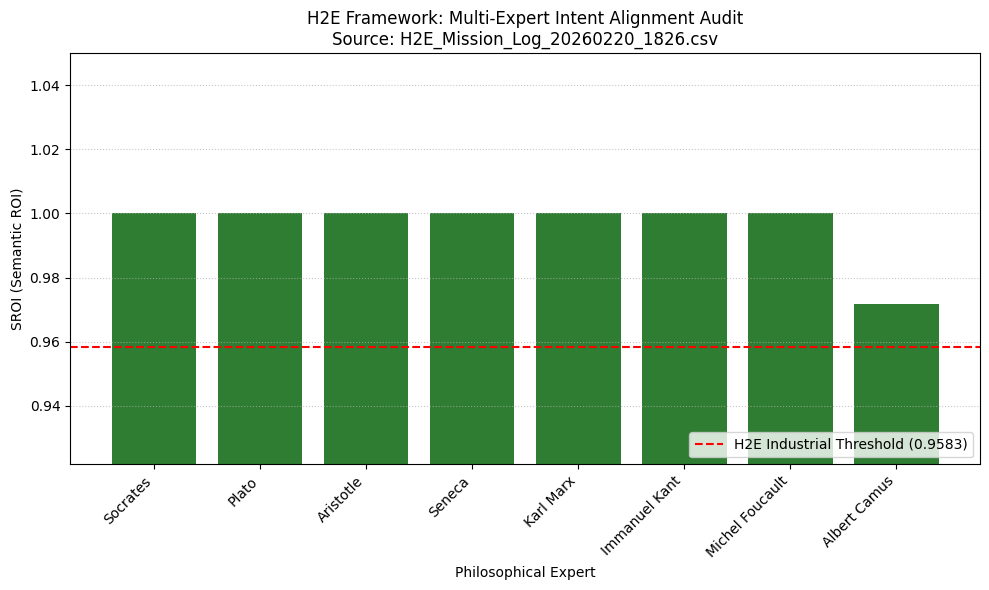

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os

# 1. Automatically locate the latest H2E Mission Log CSV
files = glob.glob("H2E_Mission_Log_*.csv")
if not files:
    raise FileNotFoundError("No H2E Mission Log CSV files found. Please run the audit first.")

latest_file = max(files, key=os.path.getctime)
print(f"Loading data from: {latest_file}")

# 2. Read SROI data directly from the CSV (No hardcoding)
df = pd.read_csv(latest_file)
df = df.sort_values(by="SROI", ascending=False)

# 3. Industrial Threshold - The "Neutral Interface" boundary
threshold = 0.9583

# 4. Visualization Logic
plt.figure(figsize=(10, 6))
colors = ['#2E7D32' if s >= threshold else '#D32F2F' for s in df["SROI"]]
plt.bar(df["Expert"], df["SROI"], color=colors)

plt.axhline(y=threshold, color='red', linestyle='--',
            label=f'H2E Industrial Threshold ({threshold})')

# Formatting for Professional Industrial Reporting
plt.ylim(df["SROI"].min() - 0.05, 1.05)
plt.ylabel('SROI (Semantic ROI)')
plt.xlabel('Philosophical Expert')
plt.title(f'H2E Framework: Multi-Expert Intent Alignment Audit\nSource: {latest_file}')
plt.xticks(rotation=45, ha='right')
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle=':', alpha=0.7)
plt.tight_layout()

# 5. Save the visualization for the H2E Archive
plt.savefig('h2e_sroi_audit_dynamic.png')